# Slack Channel Message Statistics

This notebook analyzes messages from a specific Slack channel, providing various statistics and visualizations.

## Prerequisites
1. Slack Bot Token with appropriate permissions (`channels:history`, `channels:read`, `users:read`)
2. Channel ID of the Slack channel you want to analyze

In [1]:
# Import required libraries
import os
from datetime import datetime, timedelta
import re

# Data manipulation
import pandas as pd

# Slack SDK
from slack_sdk import WebClient
from slack_sdk.errors import SlackApiError

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px

# Set up visualization style
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")


## Configuration

Update the configuration below with your Slack bot token and channel ID.


In [2]:
# Configuration
SLACK_BOT_TOKEN = os.getenv("SLACK_BOT_TOKEN")
CHANNEL_ID = os.getenv("SLACK_CHANNEL_ID")

# Analysis settings
DAYS_TO_ANALYZE = 30  # Number of days to look back
TIMEZONE = "UTC"  # Adjust to your timezone

print(
    f"Configuration set to analyze channel {CHANNEL_ID} for the last {DAYS_TO_ANALYZE} days"
)


Configuration set to analyze channel C080ECMGQ0M for the last 30 days


## Data Fetching

This section fetches messages from the specified Slack channel.


In [3]:
def fetch_channel_messages(client, channel_id, days_back=30):
    """
    Fetch messages from a Slack channel for the specified number of days.
    """
    # Calculate timestamp for days_back
    oldest_timestamp = (datetime.now() - timedelta(days=days_back)).timestamp()

    messages = []
    cursor = None

    try:
        while True:
            # Fetch messages with pagination
            response = client.conversations_history(
                channel=channel_id,
                oldest=oldest_timestamp,
                cursor=cursor,
                limit=1000,  # Maximum allowed by Slack API
            )

            messages.extend(response["messages"])

            # Check if there are more messages
            if not response.get("has_more", False):
                break

            cursor = response["response_metadata"]["next_cursor"]

    except SlackApiError as e:
        print(f"Error fetching messages: {e.response['error']}")
        return []

    print(f"Fetched {len(messages)} messages from the last {days_back} days")
    return messages


def get_user_info(client, user_id):
    """
    Get user information from Slack.
    """
    try:
        response = client.users_info(user=user_id)
        return response["user"]
    except SlackApiError as e:
        print(f"Error fetching user info for {user_id}: {e.response['error']}")
        return None


def get_channel_info(client, channel_id):
    """
    Get channel information from Slack.
    """
    try:
        response = client.conversations_info(channel=channel_id)
        return response["channel"]
    except SlackApiError as e:
        print(f"Error fetching channel info: {e.response['error']}")
        return None


In [4]:
# Initialize Slack client
client = WebClient(token=SLACK_BOT_TOKEN)

# Test connection and get channel info
print("Testing Slack connection...")
channel_info = get_channel_info(client, CHANNEL_ID)
if channel_info:
    print(f"✅ Connected to channel: #{channel_info['name']}")
    print(
        f"Channel description: {channel_info.get('purpose', {}).get('value', 'No description')}"
    )
else:
    print("❌ Failed to connect to channel. Please check your token and channel ID.")

# Fetch messages
print(f"\nFetching messages from the last {DAYS_TO_ANALYZE} days...")
raw_messages = fetch_channel_messages(client, CHANNEL_ID, DAYS_TO_ANALYZE)


Testing Slack connection...
✅ Connected to channel: #fun_pathfinder-veille-et-trashtalks
Channel description: 

Fetching messages from the last 30 days...
Fetched 67 messages from the last 30 days


## Data Processing

Let's process the raw message data and create a structured DataFrame for analysis.


In [5]:
def process_messages(messages, client):
    """
    Process raw messages into a structured format.
    """
    processed_messages = []
    user_cache = {}  # Cache user info to avoid repeated API calls

    for msg in messages:
        # Skip messages without text (like file uploads)
        if "text" not in msg or not msg["text"].strip():
            continue

        # Extract basic message info
        message_data = {
            "timestamp": float(msg["ts"]),
            "user_id": msg.get("user", "unknown"),
            "text": msg["text"],
            "type": msg.get("type", "message"),
            "subtype": msg.get("subtype", "normal"),
            "thread_ts": msg.get("thread_ts"),
            "is_thread_reply": "thread_ts" in msg
            and msg.get("thread_ts") != msg.get("ts"),
            "reactions": msg.get("reactions", []),
            "reply_count": msg.get("reply_count", 0),
        }

        # Convert timestamp to datetime
        message_data["datetime"] = datetime.fromtimestamp(message_data["timestamp"])
        message_data["date"] = message_data["datetime"].date()
        message_data["hour"] = message_data["datetime"].hour
        message_data["day_of_week"] = message_data["datetime"].strftime("%A")

        # Get user info (with caching)
        user_id = message_data["user_id"]
        if user_id not in user_cache and user_id != "unknown":
            user_info = get_user_info(client, user_id)
            if user_info:
                user_cache[user_id] = {
                    "real_name": user_info.get(
                        "real_name", user_info.get("name", "Unknown")
                    ),
                    "display_name": user_info.get("profile", {}).get(
                        "display_name", ""
                    ),
                    "is_bot": user_info.get("is_bot", False),
                }
            else:
                user_cache[user_id] = {
                    "real_name": "Unknown",
                    "display_name": "",
                    "is_bot": False,
                }

        # Add user info to message
        if user_id in user_cache:
            message_data.update(user_cache[user_id])
        else:
            message_data.update(
                {"real_name": "Unknown", "display_name": "", "is_bot": False}
            )

        # Calculate message metrics
        message_data["word_count"] = len(message_data["text"].split())
        message_data["char_count"] = len(message_data["text"])
        message_data["reaction_count"] = sum(
            reaction.get("count", 0) for reaction in message_data["reactions"]
        )

        # Check for mentions, URLs, etc.
        message_data["has_mentions"] = "<@" in message_data["text"]
        message_data["has_urls"] = "http" in message_data["text"]
        message_data["has_emoji"] = (
            ":" in message_data["text"] and message_data["text"].count(":") >= 2
        )

        processed_messages.append(message_data)

    return processed_messages


# Process the messages
print("Processing messages...")
processed_messages = process_messages(raw_messages, client)

# Create DataFrame
df = pd.DataFrame(processed_messages)
print(f"Processed {len(df)} messages into DataFrame")

# Display basic info about the dataset
print("\nDataset info:")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Unique users: {df['user_id'].nunique()}")
print(f"Bot messages: {df['is_bot'].sum()}")
print(f"Thread replies: {df['is_thread_reply'].sum()}")

# Show first few rows
df.head()


Processing messages...
Processed 65 messages into DataFrame

Dataset info:
Date range: 2025-05-24 to 2025-06-23
Unique users: 4
Bot messages: 1
Thread replies: 3


,timestamp,user_id,text,type,subtype,thread_ts,is_thread_reply,reactions,reply_count,datetime,...,day_of_week,real_name,display_name,is_bot,word_count,char_count,reaction_count,has_mentions,has_urls,has_emoji
0,1.748448e+09,U0XK4NV1R,D'ailleurs Fred MCP (le formateur) nous parlai...,message,normal,None,False,[],0,2025-05-28 18:07:13.754299,...,Wednesday,Romain Quilliot,romainjeff,False,46,292,0,True,True,True
1,1.748420e+09,U05F99L5UUT,Autre blog super intéressant sur l'usage de ag...,message,thread_broadcast,1748253394.098549,True,[],0,2025-05-28 10:20:49.855589,...,Wednesday,Julien Marinica,Julien,False,10,144,0,False,True,False
2,1.748410e+09,U0J5GV9D5,<https://youtu.be/5P-CMf3CR5A?feature=shared|h...,message,normal,None,False,"[{'name': 'face_exhaling', 'users': ['U0757U39...",0,2025-05-28 07:31:06.327519,...,Wednesday,Antoine Lépée,antoine,False,1,89,1,False,True,True
3,1.748383e+09,U0XK4NV1R,<https://x.com/bradmenezes/status/192741463863...,message,normal,1748383031.726659,False,[],1,2025-05-27 23:57:11.726659,...,Tuesday,Romain Quilliot,romainjeff,False,1,119,0,False,True,True
4,1.748362e+09,U0XK4NV1R,Un notebook qui utilise Document OCR de Mistral,message,normal,1748361522.984829,False,[],6,2025-05-27 17:58:42.984829,...,Tuesday,Romain Quilliot,romainjeff,False,8,47,0,False,False,False


## Statistical Analysis

Now let's perform various statistical analyses on the message data.


In [6]:
# Basic Statistics
print("=== BASIC CHANNEL STATISTICS ===\n")

# Overall stats
total_messages = len(df)
unique_users = df["user_id"].nunique()
date_range = (df["date"].max() - df["date"].min()).days + 1
avg_messages_per_day = total_messages / date_range
avg_messages_per_user = total_messages / unique_users

print(f"📊 Total messages: {total_messages:,}")
print(f"👥 Unique users: {unique_users}")
print(f"📅 Date range: {date_range} days")
print(f"📈 Average messages per day: {avg_messages_per_day:.1f}")
print(f"👤 Average messages per user: {avg_messages_per_user:.1f}")

# Message content stats
print("\n📝 CONTENT STATISTICS:")
print(f"Average word count: {df['word_count'].mean():.1f}")
print(f"Average character count: {df['char_count'].mean():.1f}")
print(f"Longest message: {df['char_count'].max()} characters")
print(f"Total words written: {df['word_count'].sum():,}")

# Engagement stats
print("\n💬 ENGAGEMENT STATISTICS:")
print(
    f"Messages with reactions: {(df['reaction_count'] > 0).sum()} ({(df['reaction_count'] > 0).mean() * 100:.1f}%)"
)
print(f"Total reactions: {df['reaction_count'].sum()}")
print(
    f"Thread replies: {df['is_thread_reply'].sum()} ({df['is_thread_reply'].mean() * 100:.1f}%)"
)
print(
    f"Messages with mentions: {df['has_mentions'].sum()} ({df['has_mentions'].mean() * 100:.1f}%)"
)
print(
    f"Messages with URLs: {df['has_urls'].sum()} ({df['has_urls'].mean() * 100:.1f}%)"
)

# Bot vs human stats
human_messages = df[~df["is_bot"]]
bot_messages = df[df["is_bot"]]
print("\n🤖 BOT vs HUMAN:")
print(
    f"Human messages: {len(human_messages)} ({len(human_messages) / len(df) * 100:.1f}%)"
)
print(f"Bot messages: {len(bot_messages)} ({len(bot_messages) / len(df) * 100:.1f}%)")


=== BASIC CHANNEL STATISTICS ===

📊 Total messages: 65
👥 Unique users: 4
📅 Date range: 31 days
📈 Average messages per day: 2.1
👤 Average messages per user: 16.2

📝 CONTENT STATISTICS:
Average word count: 12.3
Average character count: 153.4
Longest message: 764 characters
Total words written: 800

💬 ENGAGEMENT STATISTICS:
Messages with reactions: 46 (70.8%)
Total reactions: 92
Thread replies: 3 (4.6%)
Messages with mentions: 5 (7.7%)
Messages with URLs: 45 (69.2%)

🤖 BOT vs HUMAN:
Human messages: 64 (98.5%)
Bot messages: 1 (1.5%)


### Activity Over Time


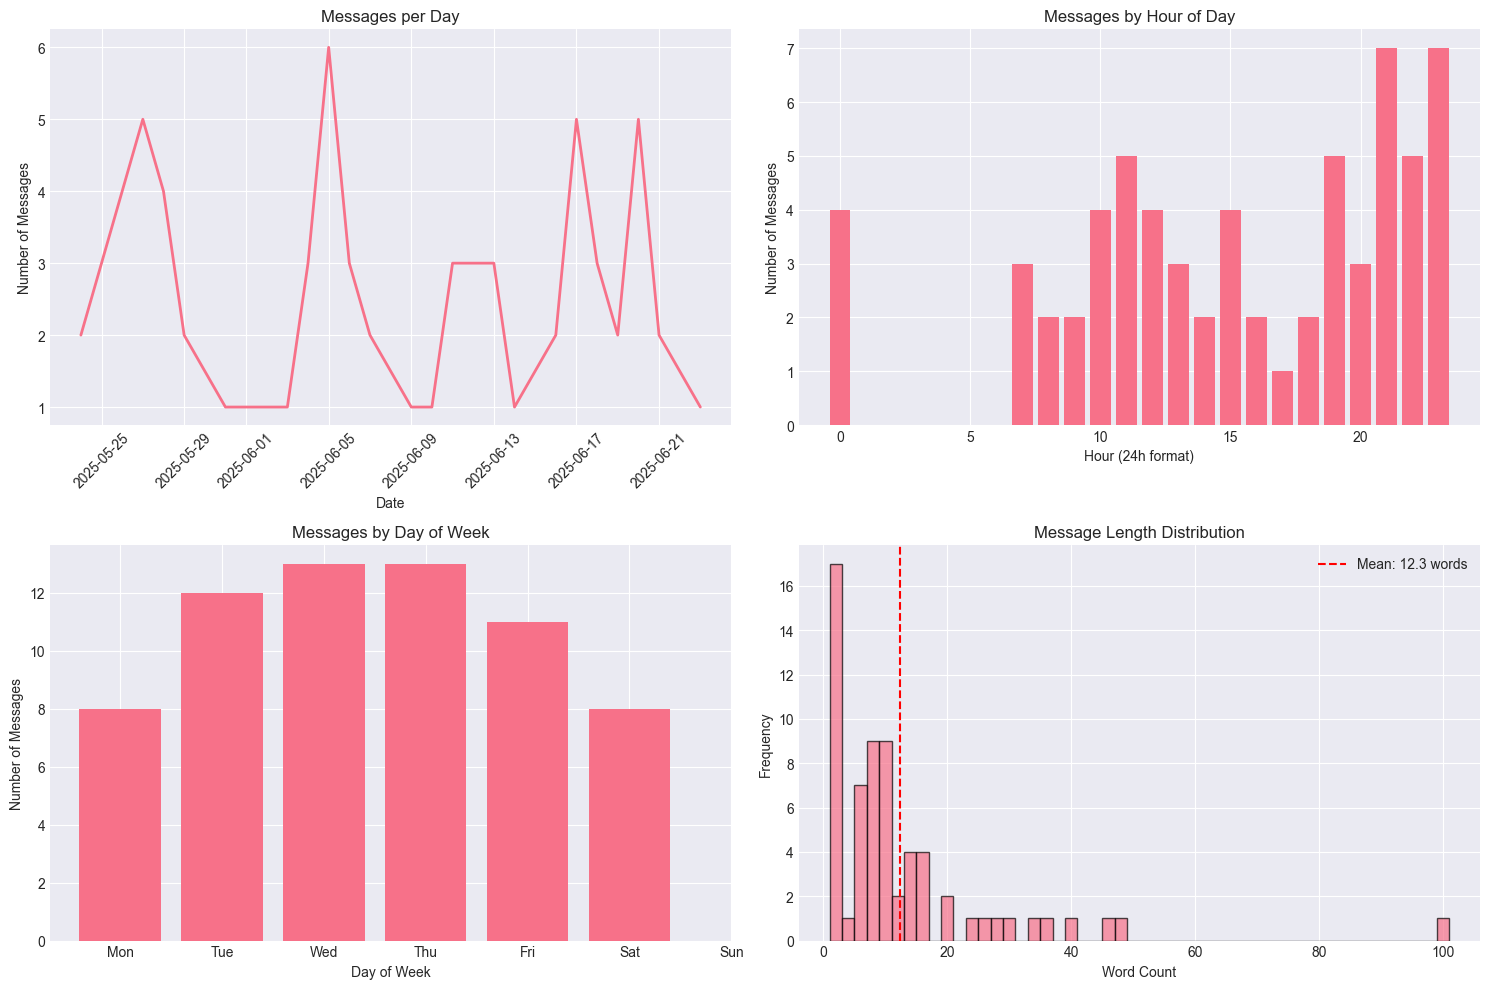

In [7]:
# Messages per day
daily_counts = df.groupby("date").size().reset_index(name="message_count")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Daily message volume
axes[0, 0].plot(daily_counts["date"], daily_counts["message_count"], linewidth=2)
axes[0, 0].set_title("Messages per Day")
axes[0, 0].set_xlabel("Date")
axes[0, 0].set_ylabel("Number of Messages")
axes[0, 0].tick_params(axis="x", rotation=45)

# Messages by hour of day
hourly_counts = df.groupby("hour").size()
axes[0, 1].bar(hourly_counts.index, hourly_counts.values)
axes[0, 1].set_title("Messages by Hour of Day")
axes[0, 1].set_xlabel("Hour (24h format)")
axes[0, 1].set_ylabel("Number of Messages")

# Messages by day of week
day_order = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]
day_counts = df.groupby("day_of_week").size().reindex(day_order)
axes[1, 0].bar(range(len(day_counts)), day_counts.values)
axes[1, 0].set_title("Messages by Day of Week")
axes[1, 0].set_xlabel("Day of Week")
axes[1, 0].set_ylabel("Number of Messages")
axes[1, 0].set_xticks(range(len(day_counts)))
axes[1, 0].set_xticklabels([day[:3] for day in day_order])

# Message length distribution
axes[1, 1].hist(df["word_count"], bins=50, alpha=0.7, edgecolor="black")
axes[1, 1].set_title("Message Length Distribution")
axes[1, 1].set_xlabel("Word Count")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].axvline(
    df["word_count"].mean(),
    color="red",
    linestyle="--",
    label=f"Mean: {df['word_count'].mean():.1f} words",
)
axes[1, 1].legend()

plt.tight_layout()
plt.show()


### User Activity Analysis


=== TOP 10 MOST ACTIVE USERS ===
                             Messages  Total_Words  Avg_Words_per_Message  Total_Reactions  Total_Characters
user_id     real_name                                                                                       
U0XK4NV1R   Romain Quilliot        37          362                   9.78               60              4262
U05F99L5UUT Julien Marinica        23          396                  17.22               30              5388
U0J5GV9D5   Antoine Lépée           4           37                   9.25                2               287


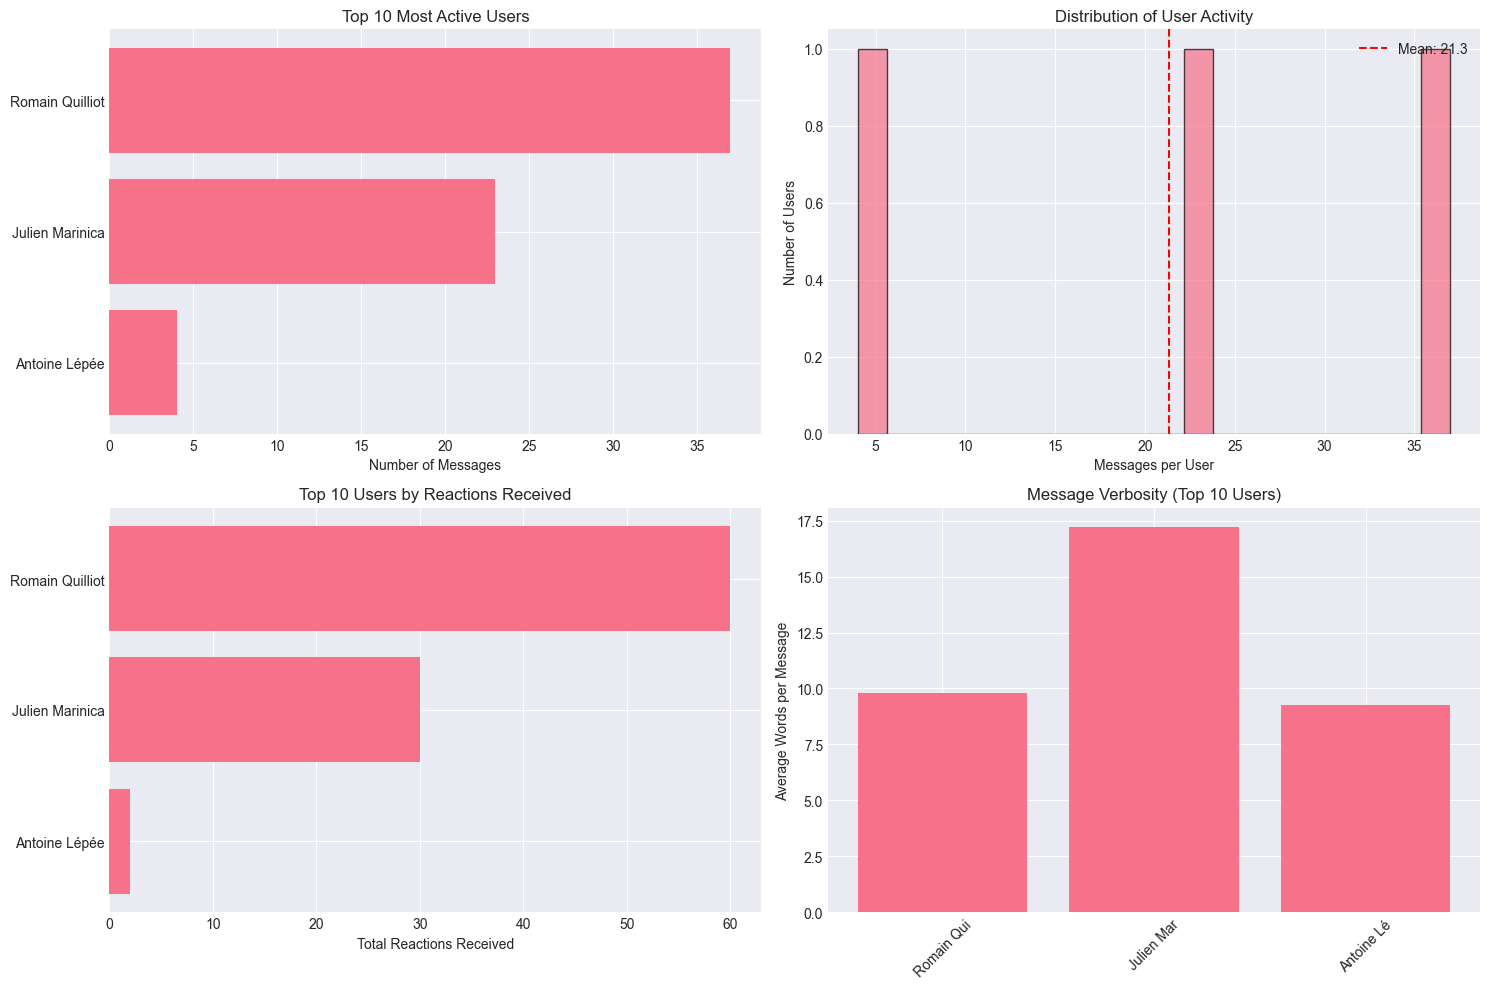

In [8]:
# User activity analysis (excluding bots)
human_df = df[~df["is_bot"]].copy()

# Top 10 most active users
user_stats = (
    human_df.groupby(["user_id", "real_name"])
    .agg(
        {
            "text": "count",
            "word_count": ["sum", "mean"],
            "reaction_count": "sum",
            "char_count": "sum",
        }
    )
    .round(2)
)

user_stats.columns = [
    "Messages",
    "Total_Words",
    "Avg_Words_per_Message",
    "Total_Reactions",
    "Total_Characters",
]
user_stats = user_stats.sort_values("Messages", ascending=False)

print("=== TOP 10 MOST ACTIVE USERS ===")
print(user_stats.head(10).to_string())

# Visualizations for user activity
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Top 10 users by message count
top_10_users = user_stats.head(10)
axes[0, 0].barh(range(len(top_10_users)), top_10_users["Messages"])
axes[0, 0].set_yticks(range(len(top_10_users)))
axes[0, 0].set_yticklabels(
    [name[1][:20] for name in top_10_users.index]
)  # Truncate long names
axes[0, 0].set_xlabel("Number of Messages")
axes[0, 0].set_title("Top 10 Most Active Users")
axes[0, 0].invert_yaxis()

# User message count distribution
axes[0, 1].hist(user_stats["Messages"], bins=20, alpha=0.7, edgecolor="black")
axes[0, 1].set_xlabel("Messages per User")
axes[0, 1].set_ylabel("Number of Users")
axes[0, 1].set_title("Distribution of User Activity")
axes[0, 1].axvline(
    user_stats["Messages"].mean(),
    color="red",
    linestyle="--",
    label=f"Mean: {user_stats['Messages'].mean():.1f}",
)
axes[0, 1].legend()

# Top users by total reactions received
top_reactions = user_stats.sort_values("Total_Reactions", ascending=False).head(10)
axes[1, 0].barh(range(len(top_reactions)), top_reactions["Total_Reactions"])
axes[1, 0].set_yticks(range(len(top_reactions)))
axes[1, 0].set_yticklabels([name[1][:20] for name in top_reactions.index])
axes[1, 0].set_xlabel("Total Reactions Received")
axes[1, 0].set_title("Top 10 Users by Reactions Received")
axes[1, 0].invert_yaxis()

# Average words per message by user (top 10 by message count)
axes[1, 1].bar(range(len(top_10_users)), top_10_users["Avg_Words_per_Message"])
axes[1, 1].set_xticks(range(len(top_10_users)))
axes[1, 1].set_xticklabels([name[1][:10] for name in top_10_users.index], rotation=45)
axes[1, 1].set_ylabel("Average Words per Message")
axes[1, 1].set_title("Message Verbosity (Top 10 Users)")

plt.tight_layout()
plt.show()


### Engagement and Content Analysis


=== ENGAGEMENT ANALYSIS ===
Messages with reactions: 46 out of 65 (70.8%)
Average reactions per engaging message: 2.00
Most reacted message: 8 reactions

=== TOP 5 MOST REACTED MESSAGES ===

👤 Romain Quilliot (2025-06-11 12:18)
❤️ 8 reactions
💬 13mn de réflexion d'o3 PRO pour ça

à sa décharge, il a tout fait en SVG car pas d'outils de gen d'i...

👤 Romain Quilliot (2025-06-16 19:26)
❤️ 6 reactions
💬 ahaha Simone qui m’envoie ça, ça m’a terminé

👤 Romain Quilliot (2025-06-05 15:00)
❤️ 5 reactions
💬 ça va y a pas beaucoup de content à générer :joy:

👤 Romain Quilliot (2025-06-04 18:57)
❤️ 5 reactions
💬 Moi à 19h :

👤 Julien Marinica (2025-06-18 22:46)
❤️ 4 reactions
💬 <https://ai.google.dev/gemini-api/docs/google-search|https://ai.google.dev/gemini-api/docs/google-se...

=== GENERATING WORD CLOUD ===


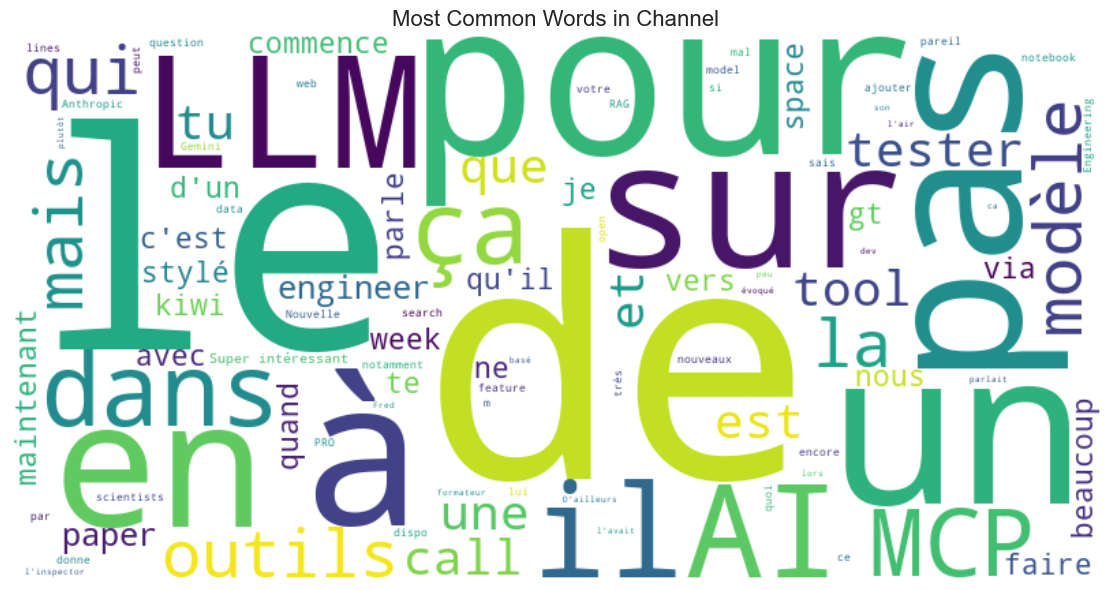


=== THREAD ANALYSIS ===
Thread replies: 3 (4.6% of all messages)
Average replies per thread: 1.0
Longest thread: 1.0 replies
Total threads: 3


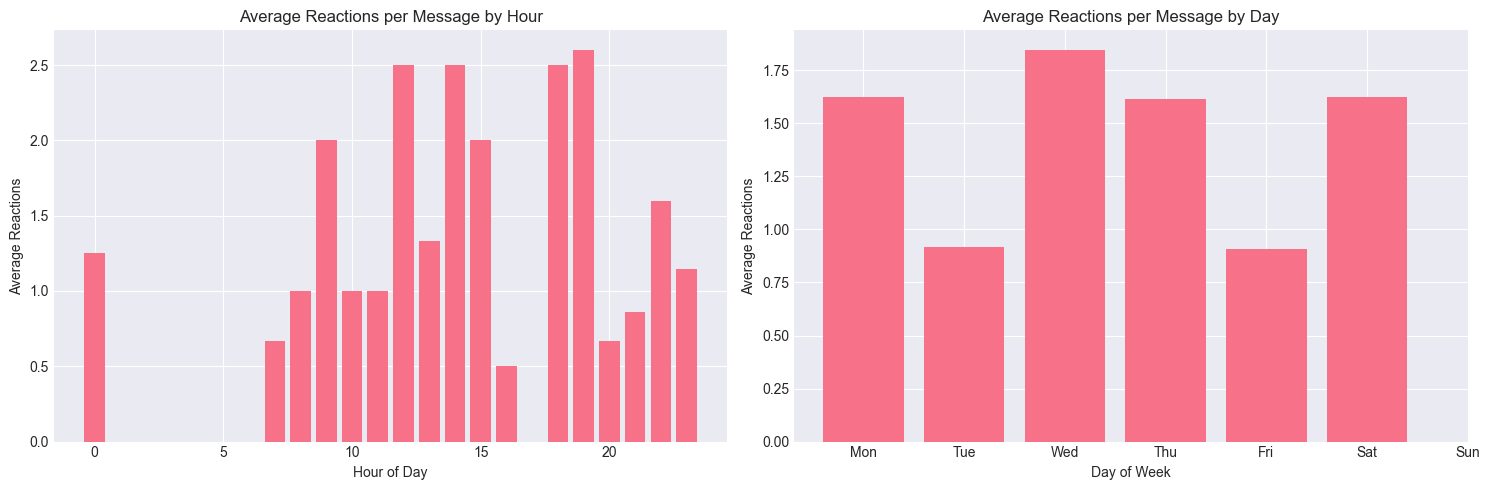

In [9]:
# Engagement Analysis
engaged_messages = df[df["reaction_count"] > 0]

print("=== ENGAGEMENT ANALYSIS ===")
print(
    f"Messages with reactions: {len(engaged_messages)} out of {len(df)} ({len(engaged_messages) / len(df) * 100:.1f}%)"
)
print(
    f"Average reactions per engaging message: {engaged_messages['reaction_count'].mean():.2f}"
)
print(f"Most reacted message: {engaged_messages['reaction_count'].max()} reactions")

# Top reacted messages
print("\n=== TOP 5 MOST REACTED MESSAGES ===")
top_reacted = df.nlargest(5, "reaction_count")[
    ["real_name", "text", "reaction_count", "datetime"]
]
for idx, row in top_reacted.iterrows():
    print(f"\n👤 {row['real_name']} ({row['datetime'].strftime('%Y-%m-%d %H:%M')})")
    print(f"❤️ {row['reaction_count']} reactions")
    print(f"💬 {row['text'][:100]}{'...' if len(row['text']) > 100 else ''}")

# Create word cloud
print("\n=== GENERATING WORD CLOUD ===")

# Combine all messages into one text
all_text = " ".join(df["text"].astype(str))

# Clean text for word cloud (remove slack-specific formatting)
clean_text = re.sub(r"<@\w+>", "", all_text)  # Remove mentions
clean_text = re.sub(r"<#\w+\|[^>]+>", "", clean_text)  # Remove channel links
clean_text = re.sub(r"<http[^>]+>", "", clean_text)  # Remove URLs
clean_text = re.sub(r":[a-zA-Z0-9_+-]+:", "", clean_text)  # Remove emoji codes

# Generate word cloud
try:
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="white",
        max_words=100,
        colormap="viridis",
    ).generate(clean_text)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Most Common Words in Channel", fontsize=16)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not generate word cloud: {e}")

# Thread analysis
thread_messages = df[df["is_thread_reply"]]
print("\n=== THREAD ANALYSIS ===")
print(
    f"Thread replies: {len(thread_messages)} ({len(thread_messages) / len(df) * 100:.1f}% of all messages)"
)

if len(thread_messages) > 0:
    thread_stats = thread_messages.groupby("thread_ts").size().describe()
    print(f"Average replies per thread: {thread_stats['mean']:.1f}")
    print(f"Longest thread: {thread_stats['max']} replies")
    print(f"Total threads: {thread_messages['thread_ts'].nunique()}")

# Time-based engagement patterns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Engagement by hour
hourly_engagement = (
    df.groupby("hour")
    .agg({"reaction_count": "mean", "text": "count"})
    .rename(columns={"text": "message_count"})
)

ax1.bar(hourly_engagement.index, hourly_engagement["reaction_count"])
ax1.set_title("Average Reactions per Message by Hour")
ax1.set_xlabel("Hour of Day")
ax1.set_ylabel("Average Reactions")

# Engagement by day of week
day_engagement = (
    df.groupby("day_of_week")
    .agg({"reaction_count": "mean", "text": "count"})
    .reindex(day_order)
    .rename(columns={"text": "message_count"})
)

ax2.bar(range(len(day_engagement)), day_engagement["reaction_count"])
ax2.set_title("Average Reactions per Message by Day")
ax2.set_xlabel("Day of Week")
ax2.set_ylabel("Average Reactions")
ax2.set_xticks(range(len(day_engagement)))
ax2.set_xticklabels([day[:3] for day in day_order])

plt.tight_layout()
plt.show()


### Interactive Dashboard

Let's create some interactive visualizations using Plotly.


In [11]:
# Interactive Plotly Dashboard

# 1. Interactive timeline of messages
daily_counts["weekday"] = pd.to_datetime(daily_counts["date"]).dt.day_name()

fig1 = px.line(
    daily_counts,
    x="date",
    y="message_count",
    title="Interactive Message Timeline",
    labels={"message_count": "Number of Messages", "date": "Date"},
    hover_data=["weekday"],
)
fig1.update_layout(height=400)
fig1.show()

# 2. Interactive heatmap of activity by hour and day
if len(df) > 0:
    # Create hour vs day heatmap data
    pivot_data = df.groupby(["day_of_week", "hour"]).size().unstack(fill_value=0)
    pivot_data = pivot_data.reindex(day_order)

    # Ensure all 24 hours are represented as columns
    all_hours = list(range(24))
    pivot_data = pivot_data.reindex(columns=all_hours, fill_value=0)

    fig2 = px.imshow(
        pivot_data.values,
        x=list(range(24)),
        y=day_order,
        aspect="auto",
        title="Activity Heatmap: Messages by Hour and Day",
        labels={"x": "Hour of Day", "y": "Day of Week", "color": "Message Count"},
        color_continuous_scale="Blues",
    )
    fig2.update_layout(height=400)
    fig2.show()

# 3. Interactive user activity
top_15_users = user_stats.head(15).reset_index()
top_15_users["display_name"] = top_15_users["real_name"].str[:25]  # Truncate names

fig3 = px.bar(
    top_15_users,
    x="Messages",
    y="display_name",
    orientation="h",
    title="Top 15 Most Active Users (Interactive)",
    labels={"Messages": "Number of Messages", "display_name": "User"},
    hover_data=["Total_Words", "Avg_Words_per_Message", "Total_Reactions"],
)
fig3.update_layout(height=600, yaxis={"categoryorder": "total ascending"})
fig3.show()

# 4. Message characteristics scatter plot
sample_df = human_df.sample(min(1000, len(human_df)))  # Sample for performance

fig4 = px.scatter(
    sample_df,
    x="word_count",
    y="reaction_count",
    size="char_count",
    color="real_name",
    title="Message Characteristics: Word Count vs Reactions",
    labels={"word_count": "Word Count", "reaction_count": "Reaction Count"},
    hover_data=["real_name", "datetime"],
)
fig4.update_layout(height=500, showlegend=False)  # Hide legend due to many users
fig4.show()


### Summary and Data Export

Generate a comprehensive summary and optionally export the data.


In [14]:
# Generate comprehensive summary
print("=" * 60)
print("                 CHANNEL ANALYSIS SUMMARY")
print("=" * 60)

# Basic stats
print("\n📊 OVERVIEW:")
print(f"   • Channel: #{channel_info['name'] if channel_info else 'Unknown'}")
print(
    f"   • Analysis period: {df['date'].min()} to {df['date'].max()} ({date_range} days)"
)
print(f"   • Total messages analyzed: {len(df):,}")
print(f"   • Unique participants: {df['user_id'].nunique()}")

# Activity patterns
busiest_day = daily_counts.loc[daily_counts["message_count"].idxmax()]
busiest_hour = df.groupby("hour").size().idxmax()
busiest_weekday = df.groupby("day_of_week").size().idxmax()

print("\n📈 ACTIVITY PATTERNS:")
print(
    f"   • Busiest day: {busiest_day['date']} ({busiest_day['message_count']} messages)"
)
print(f"   • Peak hour: {busiest_hour}:00 ({df.groupby('hour').size().max()} messages)")
print(f"   • Most active weekday: {busiest_weekday}")
print(f"   • Average daily messages: {avg_messages_per_day:.1f}")

# User engagement
most_active_user = user_stats.index[0][1] if len(user_stats) > 0 else "Unknown"
most_reacted_user = (
    user_stats.sort_values("Total_Reactions", ascending=False).index[0][1]
    if len(user_stats) > 0
    else "Unknown"
)

print("\n👥 TOP CONTRIBUTORS:")
print(
    f"   • Most active user: {most_active_user} ({user_stats.iloc[0]['Messages']} messages)"
)
print(
    f"   • Most engaging user: {most_reacted_user} ({user_stats.sort_values('Total_Reactions', ascending=False).iloc[0]['Total_Reactions']} total reactions)"
)
print(f"   • Average messages per user: {avg_messages_per_user:.1f}")

# Content insights
print("\n💬 CONTENT INSIGHTS:")
print(f"   • Average message length: {df['word_count'].mean():.1f} words")
print(f"   • Total words exchanged: {df['word_count'].sum():,}")
print(f"   • Messages with reactions: {(df['reaction_count'] > 0).mean() * 100:.1f}%")
print(f"   • Thread conversation rate: {df['is_thread_reply'].mean() * 100:.1f}%")
print(f"   • Messages with URLs: {df['has_urls'].mean() * 100:.1f}%")

print(
    "\n🎉 Analysis complete! You can re-run any cell above to refresh the analysis or modify parameters."
)

# Quick insights for future analysis
print("\n💡 INSIGHTS FOR DEEPER ANALYSIS:")
print("   • Consider analyzing message sentiment")
print("   • Look for trending topics over time")
print("   • Analyze response patterns and user interactions")
print("   • Compare activity patterns across different time periods")
print("   • Study correlation between message length and engagement")


                 CHANNEL ANALYSIS SUMMARY

📊 OVERVIEW:
   • Channel: #fun_pathfinder-veille-et-trashtalks
   • Analysis period: 2025-05-24 to 2025-06-23 (31 days)
   • Total messages analyzed: 65
   • Unique participants: 4

📈 ACTIVITY PATTERNS:
   • Busiest day: 2025-06-05 (6 messages)
   • Peak hour: 21:00 (7 messages)
   • Most active weekday: Thursday
   • Average daily messages: 2.1

👥 TOP CONTRIBUTORS:
   • Most active user: Romain Quilliot (37.0 messages)
   • Most engaging user: Romain Quilliot (60.0 total reactions)
   • Average messages per user: 16.2

💬 CONTENT INSIGHTS:
   • Average message length: 12.3 words
   • Total words exchanged: 800
   • Messages with reactions: 70.8%
   • Thread conversation rate: 4.6%
   • Messages with URLs: 69.2%

🎉 Analysis complete! You can re-run any cell above to refresh the analysis or modify parameters.

💡 INSIGHTS FOR DEEPER ANALYSIS:
   • Consider analyzing message sentiment
   • Look for trending topics over time
   • Analyze response p